In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

In [ ]:
# Load the data
products = pd.read_csv("products.csv")
similarities = pd.read_csv("similarities.csv")

# filter for similarities >= 0.9
threshold = 0.9
filtered = similarities[similarities['similarity'] >= threshold]

# mao product ID to product name
product_names = dict(zip(products['product_id'], products['product_name']))

# create a graph with only connected nodes
G = nx.Graph()

# add edges and nodes
for _, row in filtered.iterrows():
    pid1 = row['product_id_1']
    pid2 = row['product_id_2']
    G.add_edge(pid1, pid2, weight=row['similarity'])

# update node labels only for nodes that are in the graph
for node in G.nodes():
    G.nodes[node]['label'] = product_names.get(node, node)

# layout
pos = nx.spring_layout(G, k=1.5, iterations=50)

# extract node data
x_nodes = [pos[node][0] for node in G.nodes()]
y_nodes = [pos[node][1] for node in G.nodes()]
node_text = [G.nodes[node]['label'] for node in G.nodes()]

# extract edge data
x_edges, y_edges = [], []
for edge in G.edges():
    x_edges += [pos[edge[0]][0], pos[edge[1]][0], None]
    y_edges += [pos[edge[0]][1], pos[edge[1]][1], None]

# create edge trace
edge_trace = go.Scatter(
    x=x_edges, y=y_edges,
    line=dict(width=1.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# create node trace with smaller font
node_trace = go.Scatter(
    x=x_nodes, y=y_nodes,
    mode='markers+text',
    hoverinfo='text',
    textposition="top right",
    textfont=dict(size=5), 
    marker=dict(
        showscale=False,
        color='lightblue',
        size=10,
        line_width=2
    ),
    text=node_text
)

# build figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title=dict(
                        text='Skincare Product Cosine Similarity Network Graph (≥ 90%)',
                        font=dict(size=16)
                    ),
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)
                )
)

fig.show()


In [ ]:
# load csvs
products = pd.read_csv("products.csv")
similarities = pd.read_csv("similarities.csv")

# filter for similarities ≥ 0.9
threshold = 0.9
filtered = similarities[similarities['similarity'] >= threshold]

# build graph
G = nx.Graph()
for _, row in filtered.iterrows():
    pid1, pid2 = row['product_id_1'], row['product_id_2']
    G.add_edge(pid1, pid2, weight=row['similarity'])

# add category info
product_name_map = dict(zip(products['product_id'], products['product_name']))
product_category_map = dict(zip(products['product_id'], products['product_category']))
for node in G.nodes():
    G.nodes[node]['category'] = product_category_map.get(node, 'Unknown')

# assign colors
unique_categories = sorted(set(nx.get_node_attributes(G, 'category').values()))
color_palette = px.colors.qualitative.Set3
category_color_map = {cat: color_palette[i % len(color_palette)] for i, cat in enumerate(unique_categories)}

# group nodes by category
category_traces = []
category_positions = {}
x_offset = 0
for i, category in enumerate(unique_categories):
    nodes_in_cat = [n for n in G.nodes() if G.nodes[n]['category'] == category]
    subgraph = G.subgraph(nodes_in_cat)
    local_pos = nx.spring_layout(subgraph, seed=42)
    for node, (x, y) in local_pos.items():
        category_positions[node] = (x + x_offset, y)
    x_offset += 3  # space between categories

pos = category_positions

for category in unique_categories:
    x_nodes, y_nodes, node_labels = [], [], []
    for node in G.nodes():
        if G.nodes[node]['category'] == category:
            x_nodes.append(pos[node][0])
            y_nodes.append(pos[node][1])
            node_labels.append(product_name_map.get(node, node))

    trace = go.Scatter(
        x=x_nodes,
        y=y_nodes,
        mode='markers',
        name=category,
        marker=dict(color=category_color_map[category], size=10, line_width=1),
        text=node_labels,
        hoverinfo='text'
    )
    category_traces.append(trace)

# edges
x_edges, y_edges = [], []
for edge in G.edges():
    x_edges += [pos[edge[0]][0], pos[edge[1]][0], None]
    y_edges += [pos[edge[0]][1], pos[edge[1]][1], None]

edge_trace = go.Scatter(
    x=x_edges, y=y_edges,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines',
    showlegend=False
)

# plot
fig = go.Figure(data=[edge_trace] + category_traces,
                layout=go.Layout(
                    title=dict(
                        text='Skincare Product Cosine Similarity Scores Network Graph (≥ 90%)',
                        font=dict(size=16)
                    ),
                    showlegend=True,
                    legend_title=dict(text='Product Types'),
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, visible=False),
                    yaxis=dict(showgrid=False, zeroline=False, visible=False)
                )
)

fig.show()


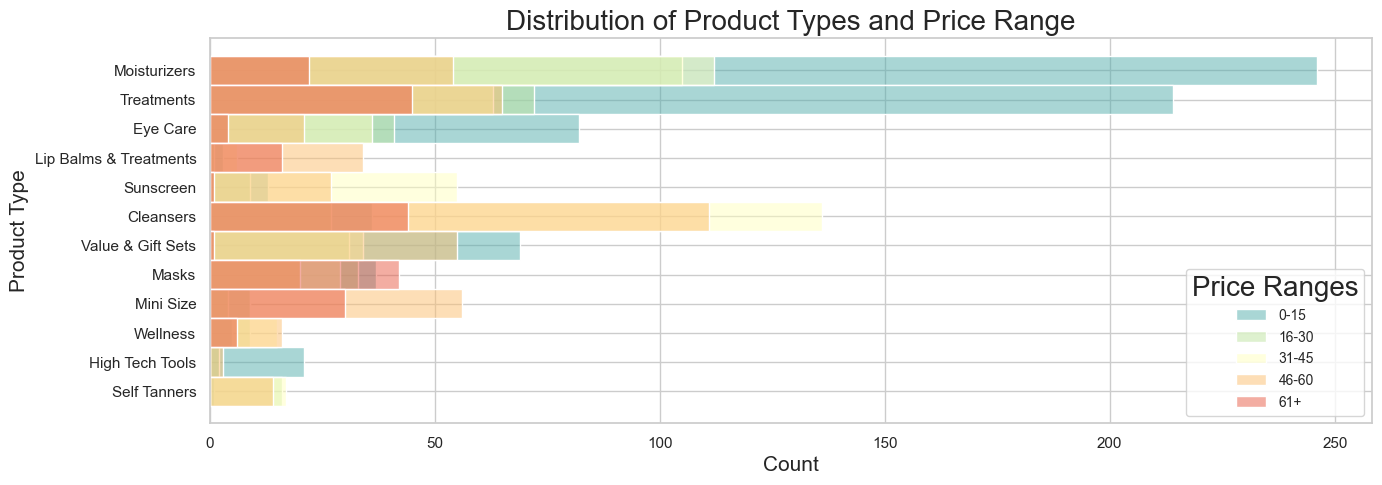

In [46]:
plt.figure(figsize=(15, 5))
products = pd.read_csv('complete_skincare_dataset.csv')
hue_order = ['0-15', '16-30', '31-45', '46-60', '61+']
ax = sns.histplot(data=products, y="product_category", hue="price_category", palette='Spectral', hue_order = hue_order)
plt.legend(title='Price Ranges', labels = hue_order)
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title
plt.ylabel("Product Type", fontsize=15)
plt.xlabel("Count", fontsize=15)
plt.title("Distribution of Product Types and Price Range", fontsize=20)
plt.show()